**Работа выполнена на Google colab**

Импорт библиотек:

In [ ]:
!pip install py_essentials
!pip install catalyst
!pip install efficientnet_pytorch

In [3]:
import os
import cv2
import statistics
import numpy as np
from scipy.stats import kurtosis, skew
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import PIL
from PIL import Image, ImageDraw
from py_essentials import hashing as hs
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
from catalyst import utils
from efficientnet_pytorch import EfficientNet

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

SEED = 42
utils.set_global_seed(SEED)

PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118
Pillow Version:  9.4.0
CUDA is available!  Training on GPU ...


In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [4]:

!nvidia-smi

Mon Nov 20 19:59:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip -q /content/drive/MyDrive/journey-springfield.zip

In [6]:
!ls train

simpsons_dataset


In [5]:
#определим директории с тренировочными и тестовыми файлами
BASE_DIR = Path('/content/drive/MyDrive/')
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset/testset')

In [6]:
#проанализируем тренировочный датасет
total = 0
print('\033[1m' + 'TRAIN:')
print('\033[0m')

persons = []
count_persons = []

folders = ([name for name in os.listdir(TRAIN_DIR)
            if os.path.isdir(os.path.join(TRAIN_DIR, name))])
for folder in folders:
    contents = os.listdir(os.path.join(TRAIN_DIR, folder))
    print('   Персонаж:', folder, ', изображений:', len(contents))
    persons.append(folder)
    count_persons.append(len(contents))
    total += len(contents)

print('\n TRAIN:', total, 'изображения с',
      len(os.listdir(TRAIN_DIR)), 'персонажами.\n')
print('\033[1m' + 'TEST:')
print('\033[0m')
print('TEST содержит:', len(os.listdir(TEST_DIR)), 'изображения.')

TRAIN:

   Персонаж: ned_flanders , изображений: 1454
   Персонаж: disco_stu , изображений: 8
   Персонаж: lenny_leonard , изображений: 310
   Персонаж: selma_bouvier , изображений: 103
   Персонаж: troy_mcclure , изображений: 8
   Персонаж: comic_book_guy , изображений: 469
   Персонаж: edna_krabappel , изображений: 457
   Персонаж: nelson_muntz , изображений: 358
   Персонаж: abraham_grampa_simpson , изображений: 913
   Персонаж: fat_tony , изображений: 27
   Персонаж: principal_skinner , изображений: 1194
   Персонаж: patty_bouvier , изображений: 72
   Персонаж: bart_simpson , изображений: 1342
   Персонаж: ralph_wiggum , изображений: 89
   Персонаж: apu_nahasapeemapetilon , изображений: 623
   Персонаж: otto_mann , изображений: 32
   Персонаж: agnes_skinner , изображений: 42
   Персонаж: waylon_smithers , изображений: 181
   Персонаж: marge_simpson , изображений: 1291
   Персонаж: maggie_simpson , изображений: 128
   Персонаж: cletus_spuckler , изображений: 47
   Персонаж: gil , из

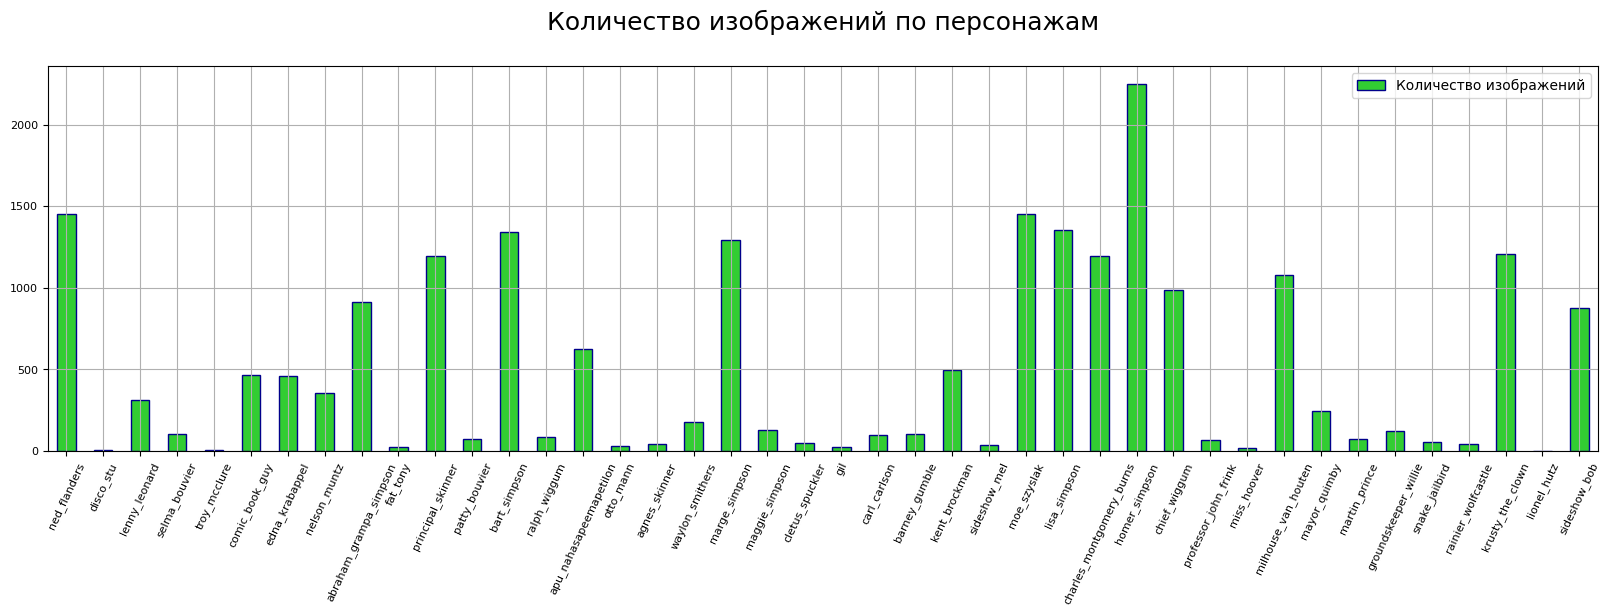

In [7]:
df = pd.DataFrame(count_persons, persons)
df.columns = ['Количество изображений']
plot = df.plot.bar(
    figsize=(20, 5), fontsize=8, color='limegreen',
    edgecolor='darkblue', linewidth=1, title='Количество изображений по персонажам\n')
plot.title.set_size(18)
plot.legend(loc=1, fontsize=10)
plot.set(ylabel=None, xlabel=None)
plot.grid()
plt.xticks(rotation=65)
plt.show()

In [8]:
#разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

In [9]:
# паддинг изображения
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'edge')

In [10]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.rescale_size = rescale_size

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)
        else:
            transform = transforms.Compose([
                SquarePad(),  # pading
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.CenterCrop(self.rescale_size * .9),
                transforms.RandomRotation(2.8),
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(p=0.5),
                    # transforms.RandomPosterize(bits=2),
                    # transforms.RandomSolarize(threshold=192.0),
                    #transforms.RandomAdjustSharpness(.9, p=0.5),
                    transforms.ColorJitter(
                                        brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(contrast=0.9)], p=0.5),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(brightness=0.1)], p=0.5),
                ]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val', rescale_size=224)
train_dataset = SimpsonsDataset(train_files, mode='train', rescale_size=224)

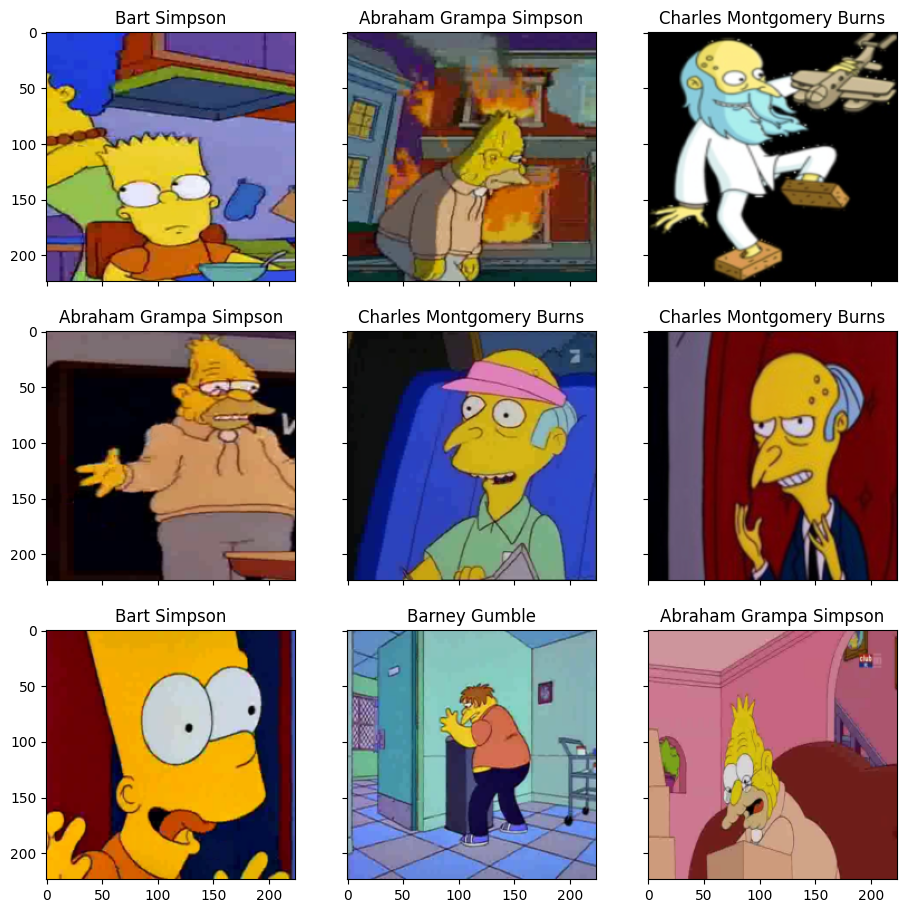

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(11, 11), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

**Инициализация модели**

In [15]:
# feature_extracting = False - вычисляем градиент у всей сети (обучаем всю модель)
# feature_extracting = True - обучаем только FC
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [16]:
def initialize_model(model_name, feature_extract, use_pretrained=True):

    model_ft = None
    # Количество классов в датасете
    num_classes = len(os.listdir(TRAIN_DIR))

    if model_name == 'efficientnet-b0':
        """ efficientnet-b0
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b0')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )
    elif model_name == 'efficientnet-b4':
        """ efficientnet-b4
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b4')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'resnet152':
        """ resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft.fc.in_features
        # меняем последний слой _fc на наш код
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

**Обучение моделей**

In [17]:
def model_learning(model_name, model_ft, rescale_size, batch_size):

    val_dataset = SimpsonsDataset(
        val_files, mode='val', rescale_size=rescale_size)
    train_dataset = SimpsonsDataset(
        train_files, mode='train', rescale_size=rescale_size)

    dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
                   'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)}
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    # Базовая скорость обучения
    base_lr = 1e-3

    # Количество эпох
    num_epochs = 10

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_ft.parameters(), lr=base_lr, betas=(
        0.0, 0.999), eps=1e-8, weight_decay=0, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[2, 4, 6, 8], gamma=0.8)

    accuracy = {"train": [], "val": []}

    for epoch in range(num_epochs):
        for k, dataloader in dataloaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model_ft.train()
                    optimizer.zero_grad()
                    outp = model_ft(x_batch)
                else:
                    model_ft.eval()
                    with torch.no_grad():
                        outp = model_ft(x_batch)
                preds = outp.argmax(-1)
                correct = (preds.detach() == y_batch).sum(dim=0)
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
        scheduler.step()

    row = {'model': model_name, 'Acc_train': round(
        max(accuracy['train']), 3), 'Acc_val': round(max(accuracy['val']), 3)}
    torch.save(model_ft.state_dict(), Path(
        str(BASE_DIR) + str('/') + str(model_name)))

    # очистка кеша
    del model_ft
    del x_batch
    del y_batch
    torch.cuda.empty_cache()

    return(accuracy, row)

In [ ]:
model_name = 'efficientnet-b4'

accuracy_b4, row_b4 = model_learning(model_name,
                                     initialize_model(model_name,
                                                      feature_extract=False,
                                                      use_pretrained=True).to(device),
                                     rescale_size=EfficientNet.get_image_size(model_name), batch_size=16)

Loaded pretrained weights for efficientnet-b4
Epoch: 1
Loader: train. Accuracy: 0.8178227912605899
Loader: val. Accuracy: 0.8782957585021016
Epoch: 2
Loader: train. Accuracy: 0.9254092617364164
Loader: val. Accuracy: 0.8975926633549867
Epoch: 3
Loader: train. Accuracy: 0.9579591056755208
Loader: val. Accuracy: 0.876958349254872
Epoch: 4
Loader: train. Accuracy: 0.9718453404675457
Loader: val. Accuracy: 0.6180741306839893
Epoch: 5
Loader: train. Accuracy: 0.9802535193324415
Loader: val. Accuracy: 0.9659915934275889
Epoch: 6
Loader: train. Accuracy: 0.9862411618574431
Loader: val. Accuracy: 0.9707680550248377
Epoch: 7
Loader: train. Accuracy: 0.991337027836168
Loader: val. Accuracy: 0.9724875811998471
Epoch: 8
Loader: train. Accuracy: 0.9938849608255302
Loader: val. Accuracy: 0.9787925105082155
Epoch: 9
Loader: train. Accuracy: 0.9971335753869673
Loader: val. Accuracy: 0.9826136797860145
Epoch: 10
Loader: train. Accuracy: 0.9987897318300528
Loader: val. Accuracy: 0.9824226213221245


In [ ]:
# сбор статистики
df_model = pd.DataFrame()
df_accuracy = pd.DataFrame()

#cохранение статистик
for row in [row_b4]:
    df_model = df_model.append(row, ignore_index=True)

for accuracy in [accuracy_b4]:
    df_accuracy = df_accuracy.append(accuracy, ignore_index=True)

df_model.to_csv(BASE_DIR/'df_model.csv', sep=',', index_label='index')
df_accuracy.to_csv(BASE_DIR/'df_accuracy.csv', sep=',', index_label='index')

<ipython-input-72-18385e22373d>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_model = df_model.append(row, ignore_index=True)
<ipython-input-72-18385e22373d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_accuracy = df_accuracy.append(accuracy, ignore_index=True)


In [ ]:
df_model = pd.read_csv(BASE_DIR/'df_model.csv', sep=',', index_col='index')
df_accuracy = pd.read_csv(BASE_DIR/'df_accuracy.csv', sep=',', index_col='index')

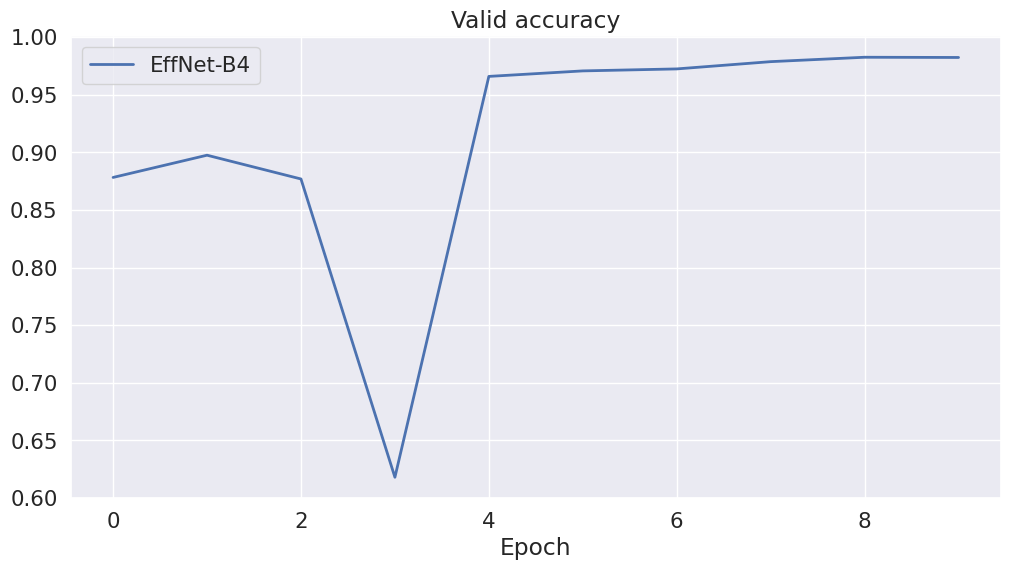

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Valid accuracy")
plt.plot(range(10), eval(df_accuracy['val'][0]), label="EffNet-B4", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

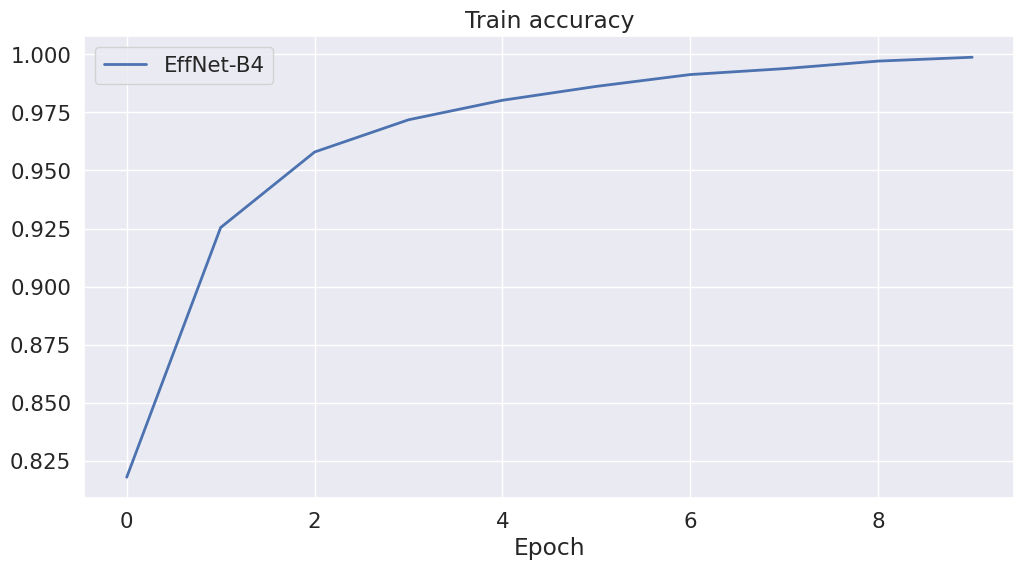

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Train accuracy")
plt.plot(range(10), eval(df_accuracy['train'][0]), label="EffNet-B4", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Загружаем лучшую сеть, и расчитываем F1 метрику**

In [ ]:
model_name = 'efficientnet-b4'

model = initialize_model(model_name, feature_extract=False, use_pretrained=True).to(device)

rescale_size = EfficientNet.get_image_size(model_name)

val_dataset = SimpsonsDataset(val_files, mode='val', rescale_size=rescale_size)
train_dataset = SimpsonsDataset(
    train_files, mode='train', rescale_size=rescale_size)

model.load_state_dict(torch.load(
    Path(str(BASE_DIR) + str('/') + str(model_name))))
model.eval()

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

In [21]:
def make_f1_score(model, n=len(val_dataset)):

    idxs = list(map(int, np.random.uniform(0, n, n)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims, -1)

    actual_labels = [val_dataset[id][1] for id in idxs]
    preds_class = list(y_pred)

    return round(f1_score(actual_labels, preds_class, average='micro'), 3).tolist()

In [22]:
device

device(type='cuda', index=0)

In [ ]:
# а вот этот подсчет Google colab не вывозит...
f1_val = make_f1_score(model)
f1_val

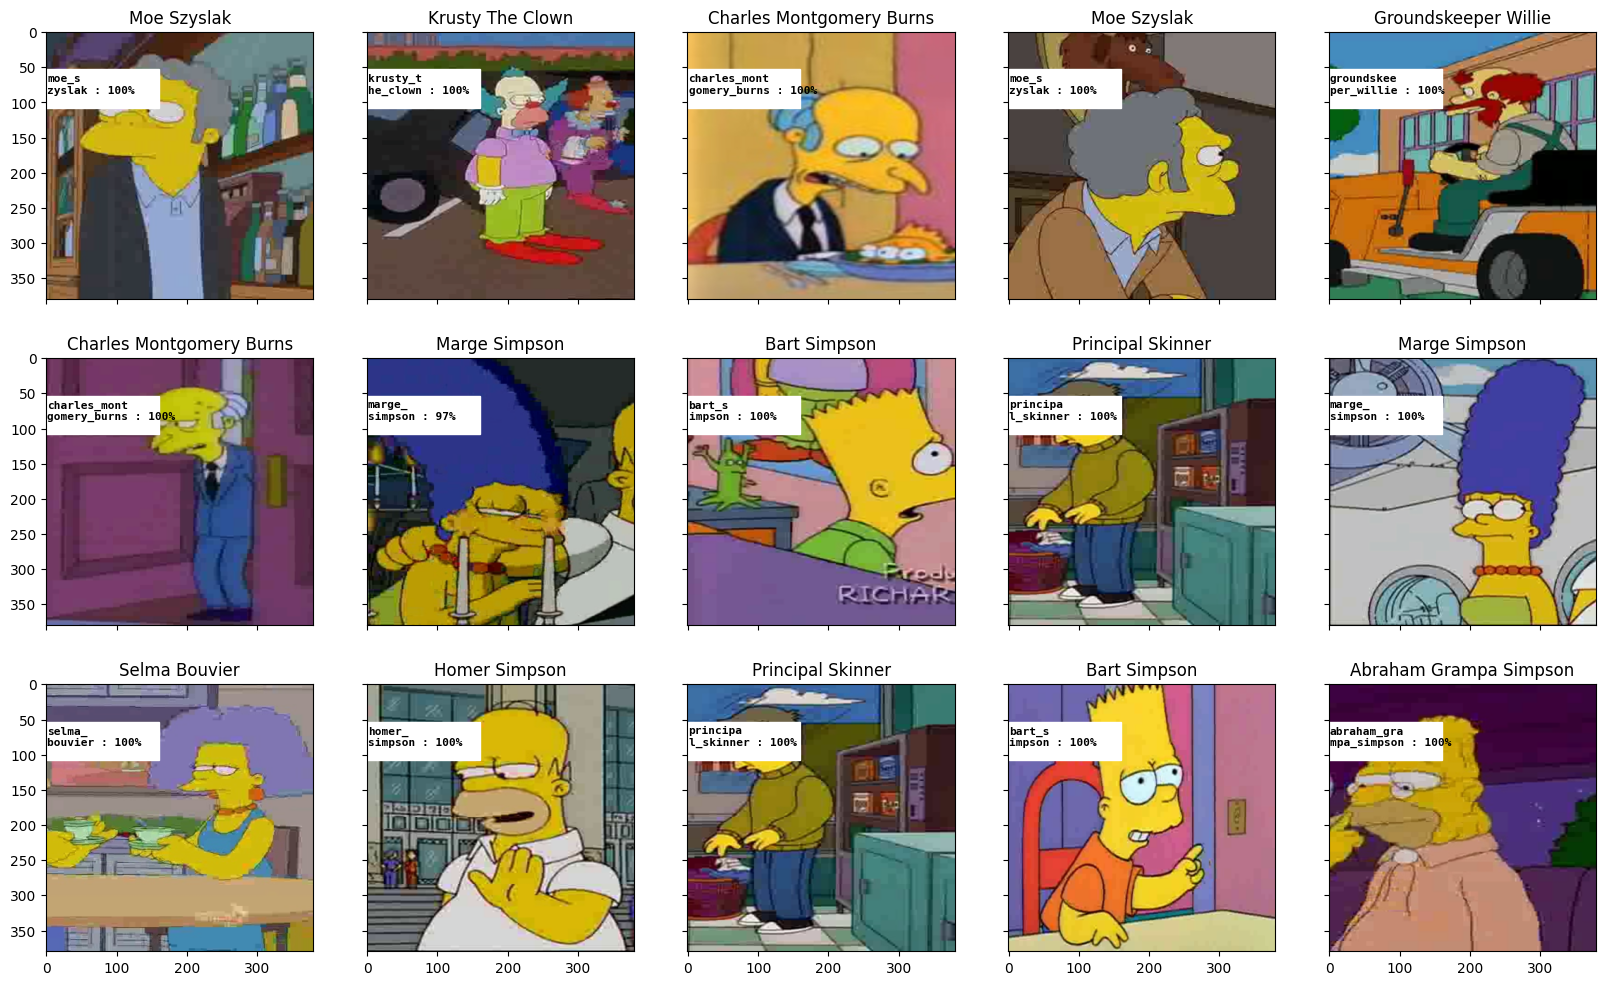

In [26]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20, 12),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 5000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(),
           title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 160, 55, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("monospace")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(
        predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
               verticalalignment='top', fontsize=8, color='black', fontweight='bold')

In [23]:
test_dataset = SimpsonsDataset(test_files, mode="test", rescale_size=rescale_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [24]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [25]:
my_submit.to_csv(BASE_DIR/'simpsons_submit.csv', index=False)